# Test version of the soil exercise NGEN16: simple diffusion model.
Course: NGEN16-2019 Code: Python</p>
Author: Harry Lankreijer

This is a test version of a Jupyter notebook to present some principles of diffusion of $CO_2$ in the soil. The exercise also introduces Jupyter Notebook as an working environment. This notebook combines (explaining) text with coding cells that contain the simulation model. Actually, notebooks can be used for data analysis and eg. shared between users to work together. Think that it can also be used to publish data analysis or to present a 'work-report' for an assignment (see an introduction to the use in [Shen, 2014](https://www.nature.com/news/interactive-notebooks-sharing-the-code-1.16261)).
In this presentation we use the programming language Python which is the default for Jupyter notebooks.
<br>
The background of the diffusion model of the production and transport of $CO_2$ is described in the exercise document. This notebooks goes stepwise through the simulation and presents the results in graphs. You can use it and for example change settings to see what the effect is in the resuls. As described in the exercise document, the notebooks presents three sub-sections: first the simulation of soil temperature, then the simulation of $CO_2$ production and finally the calculation of flux between the soil layers, the $CO_2$ concentration in each layer and the efflux of $CO_2$ out of the soil.


A programming language makes use of function libraries. So we start the calculation model with including some libraries for eg function as sinus and functions for drawing the figures. Also we define here the figure legend and line colors. As you can see we will make use of 8 layers in the top soil, including the surface

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('classic')
import numpy as np
lines=['Surface','Layer1','Layer2','Layer3','Layer4','Layer5','Layer6','Layer7']
lincolor=['black','red', 'blue', 'orange','black','red', 'blue', 'green']


<p><b> Soil temperature </b></p>
$CO_2$ production and flux are depending on soil temperature. We do not have actual measurements of the temperature for each layer, so we will estimate the temperature fluctuations following a sinus function around a constant average temperature with a given amplitude. We define a period of 10 days and a timestep of 300 s.
First we declare a number of variables and the midpoint of each layer in m below surface (below is expressed with the minus)

In [2]:
TimeStep=300 #length of time step in seconds
Day=10 #Number of days
SecDay=86400 #Number of seconds in a day
TotTime=Day*SecDay #Total number of seconds over 10 days
TotSteps=int(TotTime/TimeStep)# Number of timesteps over the period defined as integer
TempAvg=10 #average temperature over the 10 days
A0=8 #Pre-set artificial amplitude in the temperature from average
w=2*np.pi/SecDay
a=1.5E-6
zd=np.sqrt(2*a/w) #damping depth
z=[0.0,-0.05,-0.15,-0.25,-0.35,-0.45,-0.55,-0.65] #Midpoint of each 'soillayer'

The results will be stored as arrays. Here we define already arrays for the temperture and the produced CO2 (the second variable is for total production over all layers). Each array is a double array with layer and time step. Time is set to zero.

In [3]:
t=0.0 #Time is set to zero
layers= range (8)
Temp=np.zeros((8,TotSteps))
SProd=np.zeros((8,TotSteps))
SProdTot=np.zeros(TotSteps)


In the next code section the temperature is calculated in a 'for' loop: with counter k going from 0 to 'Total Timestep' the temperature is calculated for each layer (i=layer, k=TimeStep). Compare with function in exercise text:

In [4]:
for k in range(0,TotSteps): #wfor k is zero to TotSteps:
    for i in layers:
        # the temperature function
        Temp[i,k]=TempAvg+A0*np.exp(z[i]/zd)*np.sin(w*t+z[i]/zd)
        
    t=t+TimeStep    

The result is plotted in figure 1:

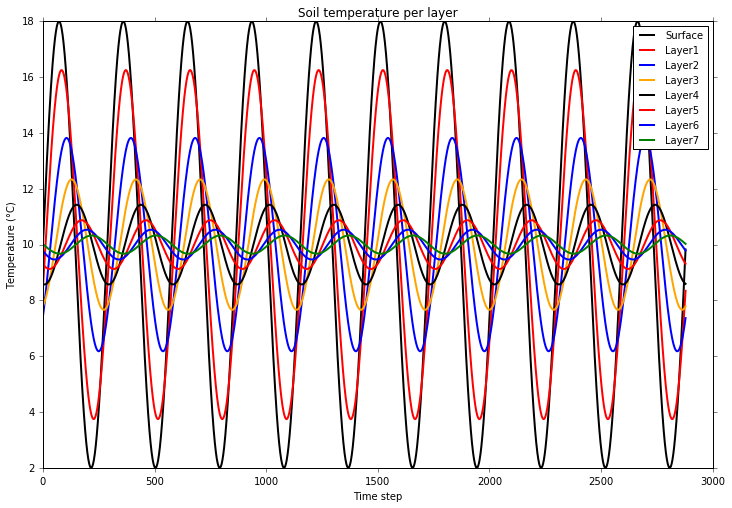

In [5]:
fig1=plt.figure(figsize=(12,8))
ax=plt.axes()
plt.rc('lines', linewidth=2)
for i in layers:
    plt.plot(Temp[i,:], color=lincolor[i], label=lines[i])
    
plt.legend(fontsize=10)
plt.title("Soil temperature per layer")
plt.ylabel("Temperature (°C)")
plt.xlabel("Time step")
ax.tick_params(axis='both', which='major', direction='out', labelsize=10)

<p><b>$CO_2$-production</b></p> Check the function for production of $CO_2$ in the exercise text. In the next code block the variables of the equation are given, as well as the SOM and root content of each layer (defined in an array)

In [6]:
#Application of CO2 production based on Michaelis-Menten temperature function
kSom=3.85e-6 #Decomposition rate organic matter mg g-1 s-1
kRoots=4.3e-5 #Respiration rate of roots mg g-1 s-1
energy=7.93E4 #Activation energy kJ mol-1
r=8.314 #Gas constant J K-1 mol-1
mSOM=[0, 3800, 2600, 1400, 500, 200, 100, 0] #Organic matter content in each layer in mg m-3
mRoots=[ 0, 578, 163, 58, 37, 5, 0, 0] #Root content in each layer in mg m-3

In the following block the $CO_2$ production from roots and SOM per layer for each time step is calculated. The Michaelis Menten temperature part of the function is taken in two steps, just to read the equation more easily. The block after that presents the resulting figure.

In [7]:

for k in range(TotSteps):
    for i in layers:
        # we split the temperature part into sections
        TempFrac1=energy/(r*(Temp[i,k]+273.15)) #Temperature from Celsius to Kelvin
        TempFrac2=((Temp[i,k]+273.15)-283.15)/283.15
        TempFrac=np.exp(TempFrac1*TempFrac2)
        #Combine it into the Michaelis-Menten based equation for CO2 production from respiration and decomposition
        SProd[i,k]=(kRoots*mRoots[i]+kSom*mSOM[i])*TempFrac
        # Sum the production per layer to total production over all layers.
        #Production is per m3, so divided by 10 for a layer of 10 cm
        SProdTot[k]=SProdTot[k]+(SProd[i,k]/10)


Plot the resulting production per layer in figure 2:

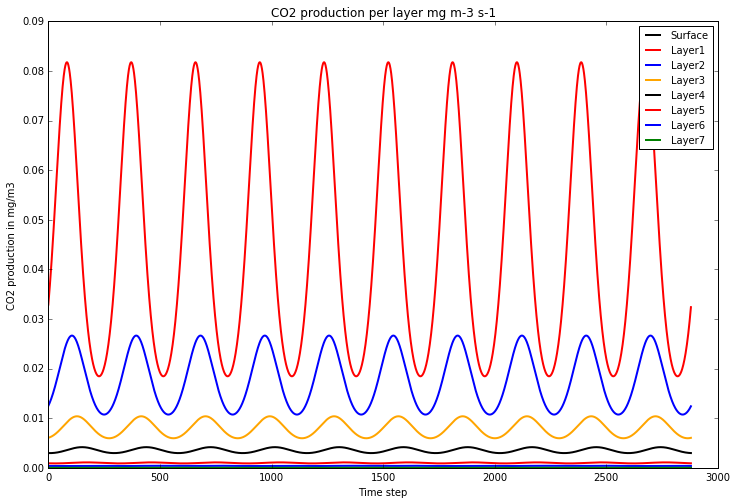

In [8]:
fig2=plt.figure(figsize=(12,8))
ax=plt.axes()
plt.rc('lines', linewidth=2)
for i in layers:
    plt.plot(SProd[i,:], color=lincolor[i], label=lines[i])
    
plt.legend(fontsize=10)
ax.set_title('CO2 production per layer mg m-3 s-1')
ax.set_ylabel('CO2 production in mg/m3')
ax.set_xlabel('Time step')
ax.tick_params(axis='both', which='major', labelsize=10)

<p><b>$CO_2$-flux</b></p>Next step is to calculate the $CO_2$ concentration per layer for each timestep. The concentration is the result of the concentration present from previous timestep, the production of $CO_2$ and the net flux out or in the layer from other layers during the actual timestep. First we calculate the diffusion coefficent for each layer depending on temperature and we define a number of start settings on $CO_2$ concentration: starting value at t=0 and keep contant concentration at the surface.

In [9]:
#Settings for the CO2 concentration and flux calculation
CO2= np.zeros((8,TotSteps)) #Definition CO2 concentration variable
DiffCoeffSoil=np.zeros((8,TotSteps)) #Definition diffusion coefficient CO2 in soil depending on temperature and tortuosity
# Estimation of diffusion coefficient for each layer and timestep
DCO2Air=1.39e-5 #Diffusion coeff for CO2 in air
AFPorosity=0.1515 #Porosity is set to 15.15%
for k in range(TotSteps): #Calculate Diffusion coeff for each layer
    DiffCoeffSoil[0,k]=DCO2Air*(((Temp[0,k]+273.15)/273.15)**1.75)
    for i in range(1,8):
        DiffCoeffSoil[i,k]=0.66*AFPorosity*DCO2Air*(((Temp[i,k]+273.15)/273.15)**1.75)
#Setting ambient concentration at surface to a constant value at 695 mg/m3
for k in range(TotSteps):
    CO2[0,k]=695

# Initial concentration is set to 695 mg/m3 for the first timestep in all layers
for i in layers: 
    CO2[i,0]=695
    


In the next cell Fick's law for diffusion is applied. First the two average diffusion coefficients between the three mid-points of the adjoining layers (i-1, i and i+1) is estimated. Then the concentration differences between the layers and vertical distance. Then Fick's law gives the net flux of the layer with the two adjoining layers (FluxLayer). The deepest layer has the lower boundary as is this calculated separate. To present the net flux into the atmosphere, the flux from the top soil into the air layer is calculated once more.

In [10]:
FluxLayer=np.zeros((8,TotSteps))

for k in range(1,TotSteps):
    for i in range(1,7): # for first soil layer to soillayer 6: last layer is treated separate due to boundary
        #First calculation of average diffusion coeff between the layers in this step, note approximation by division of 2
        Dtm1=(DiffCoeffSoil[i,k]+DiffCoeffSoil[i-1,k])/2 #Average of Diff coeff between layer i and layer above i-1
        Dtm2=(DiffCoeffSoil[i,k]+DiffCoeffSoil[i+1,k])/2 #Average of Diff coeff between layer i and layer below i+1
        #Then calculation of concentration differences and thickness of layers (although set constant to 0.1 m)
        C1=CO2[i-1,k-1]-CO2[i,k-1] #difference in concentration layer i-1 and i
        C2=CO2[i,k-1]-CO2[i+1,k-1] #difference in concentration layer i and i+1
        Z1=z[i-1]-z[i] # difference in depth between layers i-1 and i
        Z2=z[i]-z[i+1] # difference in depth between layers i and i+1
        #Estimation of flux between layers from concentration differences of previous timestep
        #Net flux to/from the layer is the sum of the two fluxes from top and bottom of layer
        #Flux from Fick's law: diffusion coeff times ratio dc/dz; minus sign is for correct direction of flux
        FluxLayer[i,k]=-Dtm1*(C1/Z1)+Dtm2*(C2/Z2)
    
    # for lowest soillayer
    Dtm1=(DiffCoeffSoil[7,k]+DiffCoeffSoil[6,k])/2
    FluxLayer[7,k]=-Dtm1*((CO2[6,k-1]-CO2[7,k-1])/(z[6]-z[7]))
    for i in range(1,8):
        # for all soil layers the concentration for actual timestep with assumption that
        # dz is set 10 cm just for now
        CO2[i,k]=CO2[i,k-1]-(FluxLayer[i,k]/0.1)*TimeStep + (SProd[i,k]*TimeStep)
        
    # estimation of net efflux from the top soil into air-layer
    Dtm1=(DiffCoeffSoil[0,k]+DiffCoeffSoil[1,k])/2
    FluxLayer[1,k]=-Dtm1*((CO2[0,k-1]-CO2[1,k-1])/(z[0]-z[1]))
                        

Results are presented in figure 3 and 4: $CO_2$ concentration per layer and net flux from the soil.

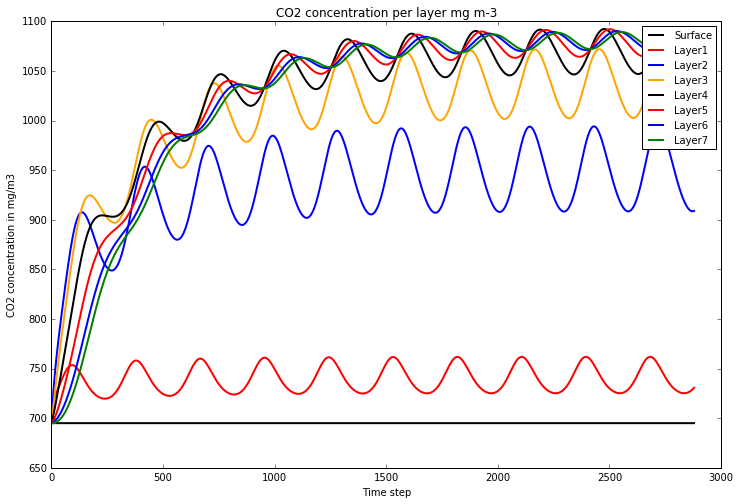

In [11]:
fig3=plt.figure(figsize=(12,8))
ax=plt.axes()

for i in layers:
    plt.plot(CO2[i,:], color=lincolor[i], label=lines[i])

plt.legend(fontsize=10)
ax.set_title("CO2 concentration per layer mg m-3")
ax.set_ylabel('CO2 concentration in mg/m3')
ax.set_xlabel('Time step')
ax.tick_params(axis='both', which='major', labelsize=10)

For comparison, the total production over all layers is given togther with the net flux from the soil.

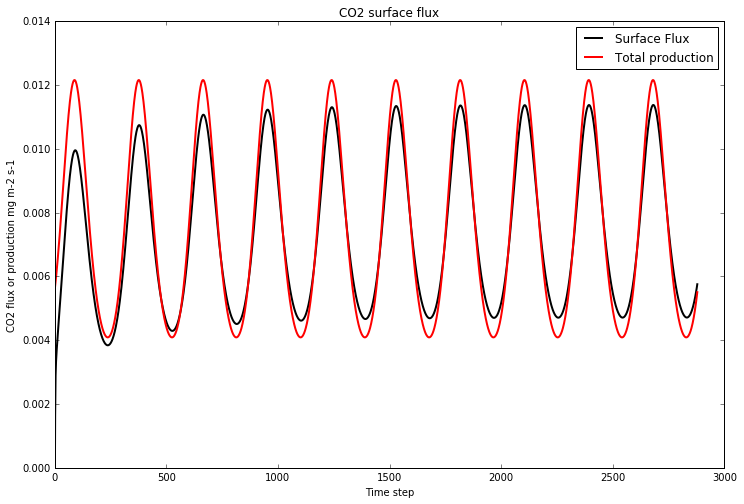

In [12]:
fig4=plt.figure(figsize=(12,8))
ax=plt.axes()
plt.plot(FluxLayer[1,:], color='Black', label='Surface Flux')
plt.plot(SProdTot[:], color='Red', label='Total production')
plt.legend()
ax.set_title("CO2 surface flux")
ax.set_ylabel("CO2 flux or production mg m-2 s-1")
ax.set_xlabel("Time step")
ax.tick_params(axis='both', which='major', labelsize=10)